# Prepare MCV data

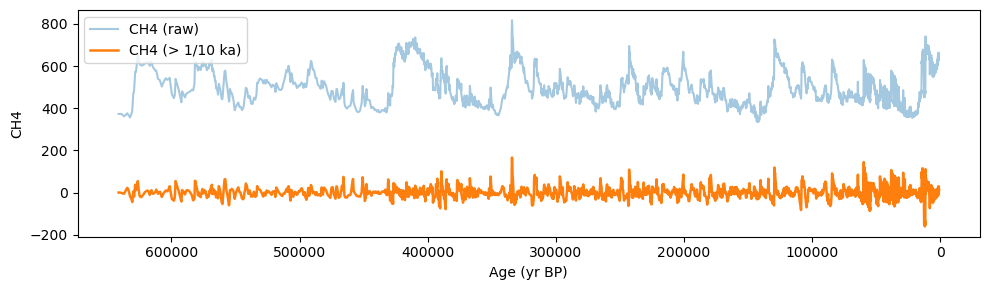

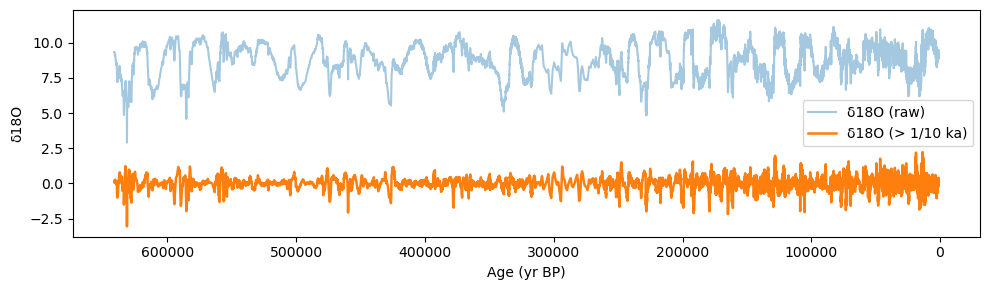

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from toolbox import sq_ana as sa 
import importlib
importlib.reload(sa)


# 0) Load raw data
df_ch4 = pd.read_excel('other_data/CH4_AICC2023.xlsx', sheet_name='Sheet1')
file_path = r"D:\VScode\bipolar_seesaw_CCM\other_data\monsoon.xlsx"
df_d18O = pd.read_excel(file_path)
df_d18O['age'] *= 1000  # to yrs BP
df_d18O['d18O'] = df_d18O['d18O'].values*-1
# renmae column d18O to 'd18O*-1'
df_d18O.rename(columns={'d18O': '-d18O'}, inplace=True)

dt=10
# 1) Build common 10-yr age grid over their overlap
age_min = 1000 # max(df_ch4['age'].min(), df_d18O['age'].min())
age_max = min(df_ch4['age'].max(), df_d18O['age'].max())
ages = np.arange(age_min, age_max + 1, dt)

# 2) Interpolate each onto that grid
ch4 = np.interp(ages, df_ch4['age'], df_ch4['ch4'])
d18O = np.interp(ages, df_d18O['age'], df_d18O['-d18O'])



df_ch4_interp = pd.DataFrame({'age':ages, 'ch4':ch4})
df_d18O_interp = pd.DataFrame({'age':ages, 'd18O':d18O})


df_filt_ch4, df_filt_d18O = sa.highpass_ch4_d18O(
    df_ch4_interp,          # DataFrame with columns ['age','ch4']
    df_d18O_interp,         # columns ['age','d18O']
    cutoff_period = 10000, # high-pass >1/10 ka
    plot = True             # quick comparison plot
)




# df_filt_ch4, df_filt_d18O = sa.bandpass_ch4_d18o(
#     df_ch4_interp,
#     df_d18O_interp,
#     low_period = 100,     # keep variability slower than 300 yr
#     high_period = 10_000,  # and faster than 3 ka
#     flip_sign = False,
#     plot = True
# )


# Read LR04

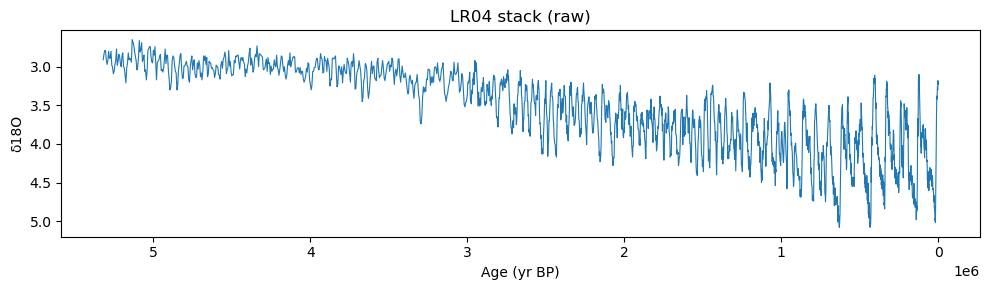

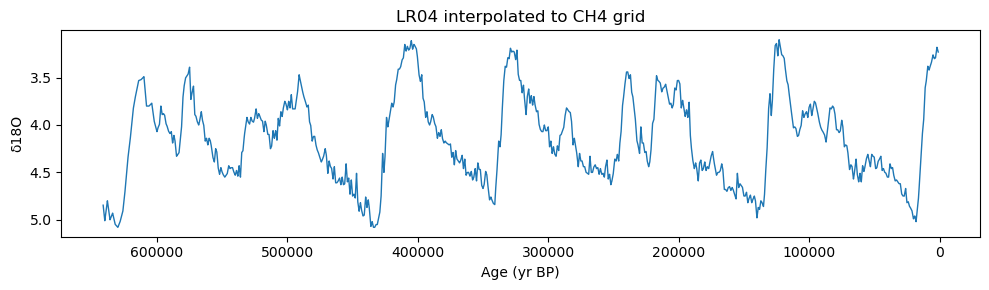

Text(0.5, 0, 'd18O')

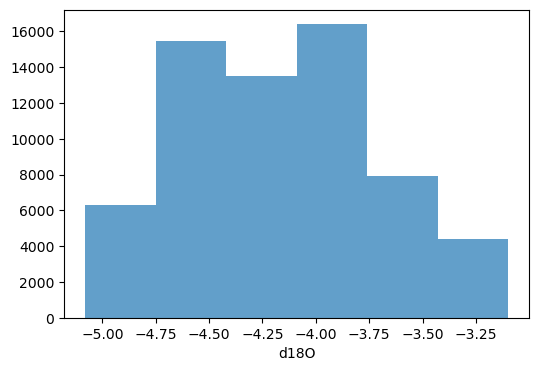

In [20]:
from toolbox import sq_ana as sa 
import importlib
importlib.reload(sa)

df_lr04_interp = sa.interpolate_data_lr04(
    df_filt_ch4,      # any DataFrame with an 'age' column
    if_plot=True
)


df_lr04_interp['d18O']=df_lr04_interp['d18O']*-1


# plot histogram of d18O
plt.figure(figsize=(6, 4))
plt.hist(df_lr04_interp['d18O'], bins=6, color='C0', alpha=0.7)
plt.xlabel('d18O')

# LR04 to CH4 MCV square wave (to remove the influence of uneven temporal resolution in CH4)

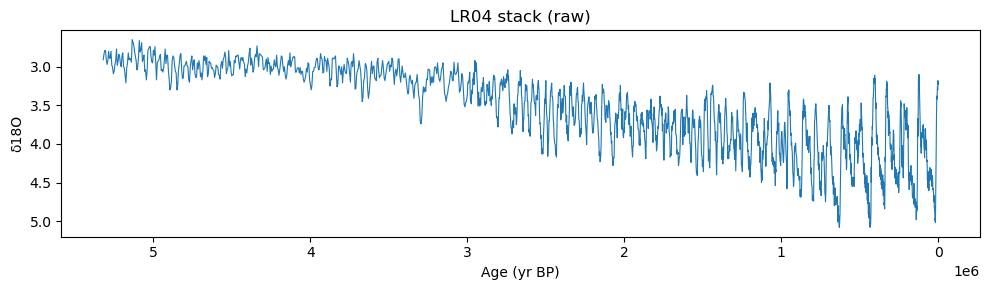

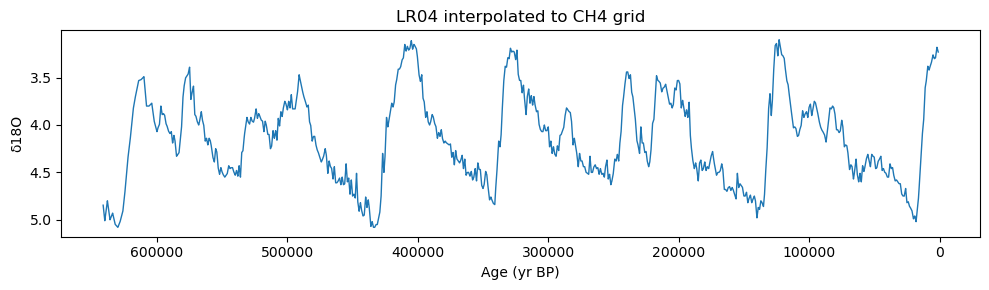

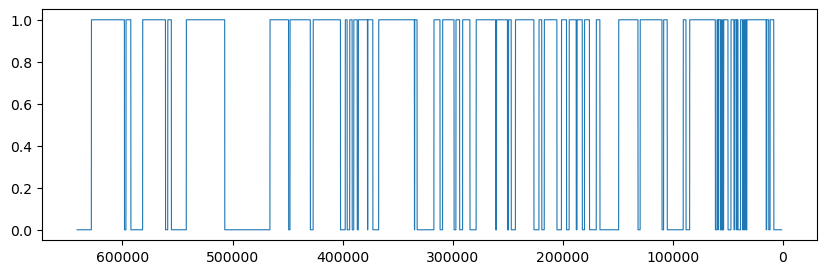

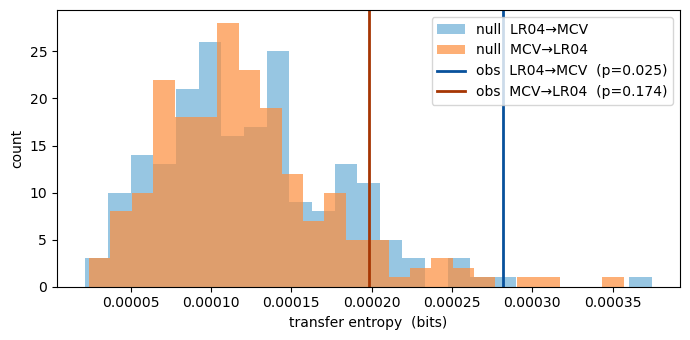

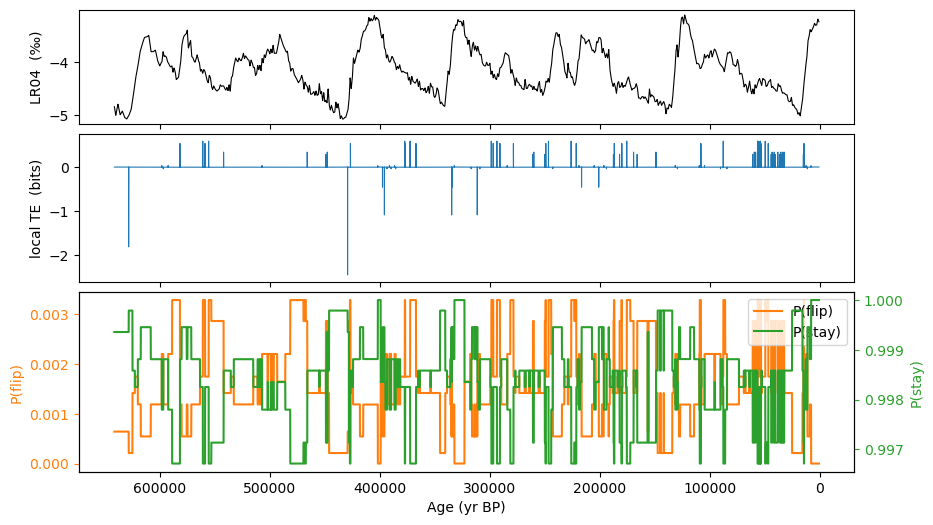

In [21]:
from toolbox import sq_ana as sa 
import importlib
importlib.reload(sa)

df_lr04_interp = sa.interpolate_data_lr04(
    df_filt_ch4,      # any DataFrame with an 'age' column
    if_plot=True
)


df_lr04_interp['d18O']=df_lr04_interp['d18O']*-1

lr04= df_lr04_interp['d18O'].values  # LR04 benthic stack
sq = df_filt_ch4['filt_ch4'].values    # target (residual)

lr04=lr04[::-1] # flip the data so it has correct time direction
sq=sq[::-1] # flip the data so it has correct time direction





import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyinform import transfer_entropy




sigma      = np.std(sq)                  # 1-σ threshold
state_raw  = np.full_like(sq, fill_value=np.nan, dtype=float)

# state_raw[sq <= -1.5*sigma] = 0              # cold  (0)
# state_raw[sq >=  1.5*sigma] = 1              # warm  (1)

multiplier = 1.5
state_raw[sq <= -1*multiplier*sigma] = 0              # cold  (0)
state_raw[sq >=  multiplier*sigma] = 1              # warm  (1)

# hold previous state through the “neutral” belt  (run-length filter)
state = state_raw.copy()
for i in range(1, len(state)):
    if np.isnan(state[i]):
        state[i] = state[i-1]
# still NaN at t=0?  set to the first non-NaN afterwards
first_valid = np.where(~np.isnan(state))[0][0]
state[:first_valid] = state[first_valid]

state = state.astype(int)                # now 0/1 sequence

# plot state
plt.figure(figsize=(10, 3))
plt.plot(df_filt_ch4['age'].values[::-1], state, lw=0.8)
# reverse x
plt.gca().invert_xaxis()

# ------------------------------------------------------------------
# 2.  LR04 → 6 equal-width bins
# ------------------------------------------------------------------
nbins_pre = 6
bins_pre  = np.histogram_bin_edges(lr04, bins=nbins_pre)
x_disc    = np.clip(np.digitize(lr04, bins_pre) - 1, 0, nbins_pre-1)




# ------------------------------------------------------------------
#  A.  global TE in both directions
# ------------------------------------------------------------------
te_xy = transfer_entropy(x_disc[:-1], state[1:], k=1)  # LR04 -> MCV
te_yx = transfer_entropy(state[:-1],  x_disc[1:], k=1) # MCV  -> LR04

# ------------------------------------------------------------------
#  B.  permutation surrogates
# ------------------------------------------------------------------
n_surr = 200
null_xy = np.empty(n_surr)
null_yx = np.empty(n_surr)
rng = np.random.default_rng(0)

for s in range(n_surr):
    xs = rng.permutation(x_disc)
    ys = rng.permutation(state)
    null_xy[s] = transfer_entropy(xs[:-1], state[1:], k=1)
    null_yx[s] = transfer_entropy(ys[:-1], x_disc[1:], k=1)

# two-tailed p-values
cnt_hi_xy = np.sum(null_xy >= te_xy)
cnt_lo_xy = np.sum(null_xy <= te_xy)
p_xy = (2 * min(cnt_hi_xy, cnt_lo_xy) + 1) / (n_surr + 1)

cnt_hi_yx = np.sum(null_yx >= te_yx)
cnt_lo_yx = np.sum(null_yx <= te_yx)
p_yx = (2 * min(cnt_hi_yx, cnt_lo_yx) + 1) / (n_surr + 1)

# ------------------------------------------------------------------
#  C.  plot null distributions + observed TE
# ------------------------------------------------------------------
plt.figure(figsize=(7,3.5))
plt.hist(null_xy, bins=25, color='#6baed6', alpha=.7, label='null  LR04→MCV')
plt.hist(null_yx, bins=25, color='#fd8d3c', alpha=.7, label='null  MCV→LR04')

plt.axvline(te_xy, color='#08519c', lw=2,
            label=f'obs  LR04→MCV  (p={p_xy:.3f})')
plt.axvline(te_yx, color='#a63603', lw=2,
            label=f'obs  MCV→LR04  (p={p_yx:.3f})')

plt.xlabel('transfer entropy  (bits)')
plt.ylabel('count')
plt.legend(frameon=True); plt.tight_layout(); plt.show()


local_te  = transfer_entropy(x_disc, state, k=1, local=True).flatten()
local_te  = local_te[1:]   

x_prev = x_disc[:-1]
y_prev = state[:-1]
y_next = state[1:]

counts = np.zeros((nbins_pre, 2, 2), dtype=int)   # (pre , sq_prev , sq_next)
for xi, yi, zi in zip(x_prev, y_prev, y_next):
    counts[xi, yi, zi] += 1

totals     = counts.sum(axis=2, keepdims=True)
with np.errstate(divide='ignore', invalid='ignore'):
    cond_p = counts / totals                      # P(y_next | x_prev , y_prev)

p_flip = np.array([cond_p[x, y, 1-y] for x,y in zip(x_prev, y_prev)])
p_stay = np.array([cond_p[x, y,   y] for x,y in zip(x_prev, y_prev)])



ages=df_filt_ch4['age'].values[::-1]
# ---------------- align lengths  -----------------
N = min(len(local_te), len(p_flip), len(p_stay), len(ages)-1)
local_te = local_te[:N]
p_flip   = p_flip[:N]
p_stay   = p_stay[:N]
t_plot   = ages[1:1+N]


# ------------------------------------------------------------------
#  D.  LR04, local TE, P(flip)/P(stay) stacked
# ------------------------------------------------------------------
fig = plt.figure(figsize=(10,6))
gs  = fig.add_gridspec(3, 1, height_ratios=[0.7, 0.9, 1.1], hspace=0.07)

# panel A – LR04 (sign-flipped)
axA = fig.add_subplot(gs[0])
axA.plot(ages, lr04, color='k', lw=0.8)
axA.set_ylabel('LR04  (‰)')
axA.invert_xaxis()
axA.tick_params(axis='x', labelbottom=False)

# panel B – local TE
axB = fig.add_subplot(gs[1], sharex=axA)
axB.plot(t_plot, local_te, lw=0.8, color='C0')
axB.set_ylabel('local TE  (bits)')
axB.tick_params(axis='x', labelbottom=False)

# panel C – P(flip) & P(stay)
axC  = fig.add_subplot(gs[2], sharex=axA)
lnF, = axC.plot(t_plot, p_flip, color='C1', label='P(flip)')
axC.set_ylabel('P(flip)', color='C1')
axC.tick_params(axis='y', colors='C1')
axD = axC.twinx()
lnS, = axD.plot(t_plot, p_stay, color='C2', label='P(stay)')
axD.set_ylabel('P(stay)', color='C2')
axD.tick_params(axis='y', colors='C2')
axC.set_xlabel('Age (yr BP)')
axC.legend([lnF, lnS], ['P(flip)', 'P(stay)'], loc='upper right')

plt.show()



# Compare the MCV sequence during the last glacial period under given sigma with NGRIP MCV sequence 

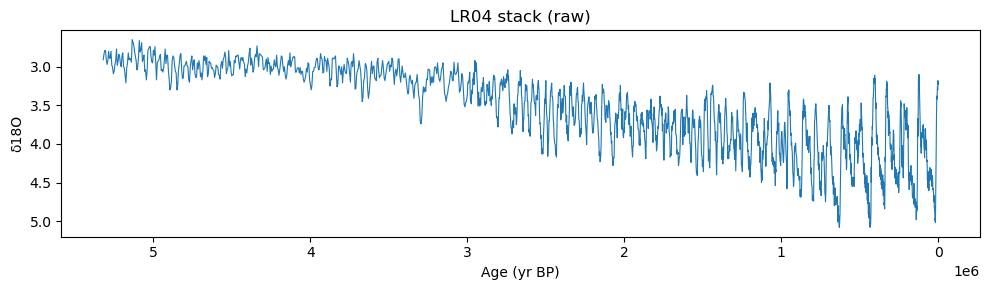

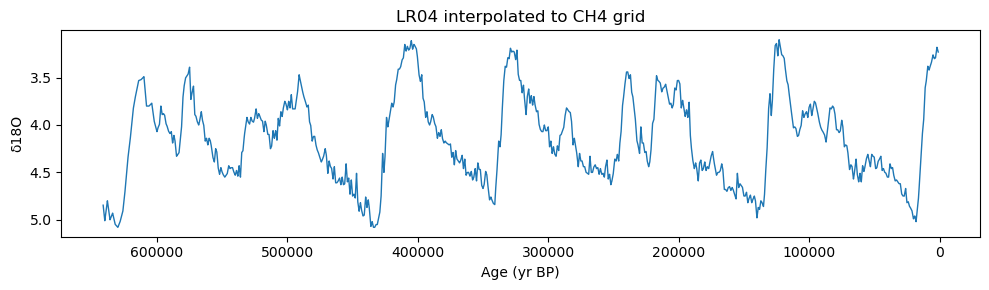

σ‐multiplier = 1.50   |   thr = 37.0396
   →  F1(cold) = 0.3844    |   Predicted runs = 17
   →  Penalty = 0.1286    |   Score = 0.2559


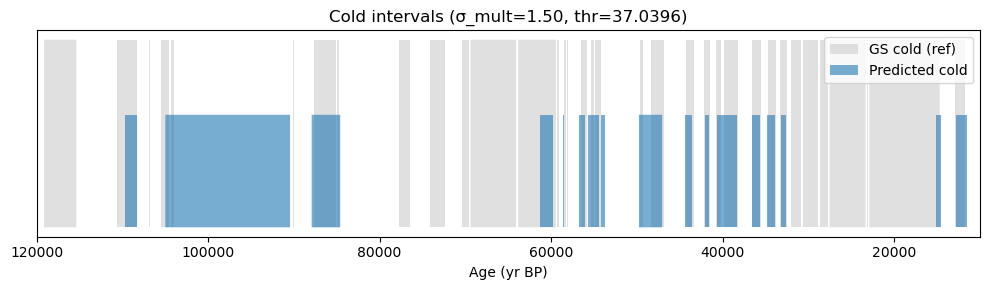

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from pyinform import transfer_entropy
from toolbox import sq_ana as sa
import importlib
importlib.reload(sa)

# ------------------------------------------------------------------
#  A) Prepare / interpolate data exactly as before
# ------------------------------------------------------------------
df_lr04_interp = sa.interpolate_data_lr04(
    df_filt_ch4,      # any DataFrame with an 'age' column
    if_plot=True
)

# Crop the LR04‐interpolated DataFrame to age ≥ 10 000 yr BP
df_lr04_interp = df_lr04_interp[df_lr04_interp['age'] >= 10_000].reset_index(drop=True)
df_lr04_interp['d18O'] *= -1

# Build the “full” CH₄ array (flipped into forward time)
sq_full      = df_filt_ch4['filt_ch4'].values[::-1]
ages_full_ch4 = df_filt_ch4['age'].values[::-1]

# Build the “full” LR04 array (flipped into forward time)
ages_full_lr04 = df_lr04_interp['age'].values[::-1]
lr04_full     = df_lr04_interp['d18O'].values[::-1]

# Compute σ on the ENTIRE CH₄ record (sq_full)
sigma_full = np.std(sq_full)


# GS (Greenland Stadial) start/end ages (labels refer to 10–120 ka window)
gs_data = {
    "start": np.array([11703, 14692, 23020, 23340, 27780, 28900, 30840, 32500, 33740, 35480,
                       38220, 40160, 41460, 43340, 46860, 49280, 54220, 55000, 55800, 58040,
                       58280, 59080, 59440, 64100, 69620, 72340, 76440, 84760, 85060, 90040,
                       104040,104520,106750,108280,115370]),
    "end":   np.array([12896, 22900, 23220, 27540, 28600, 30600, 32040, 33360, 34740, 36580,
                       39900, 40800, 42240, 44280, 48340, 49600, 54900, 55400, 56500, 58160,
                       58560, 59300, 63840, 69400, 70380, 74100, 77760, 84960, 87600, 90140,
                       104380,105440,106900,110640,119140])
}

# ------------------------------------------------------------------
#  B) Define the 10–120 ka window and build small “cropping” masks
# ------------------------------------------------------------------
age_min, age_max = 10_000, 120_000

# mask on df_lr04_interp  (these two masks will end up being identical in length/order,
# because sa.interpolate_data_lr04 aligned LR04 onto the same age‐grid as df_filt_ch4)
mask_range_lr04 = (df_lr04_interp['age'] >= age_min) & (df_lr04_interp['age'] <= age_max)
mask_range_ch4  = (df_filt_ch4['age'] >= age_min) & (df_filt_ch4['age'] <= age_max)

# Build the “cropped” age / data arrays (10–120 ka), reversed to forward‐time:
ages   = df_lr04_interp.loc[mask_range_lr04, 'age'].iloc[::-1].values
lr04    = df_lr04_interp.loc[mask_range_lr04, 'd18O'].iloc[::-1].values
sq      = df_filt_ch4.loc[mask_range_ch4, 'filt_ch4'].iloc[::-1].values

# Sanity check: these three must all be the same length
assert len(ages) == len(lr04) == len(sq)

# Build GS boolean mask (10–120 ka) on this “ages” vector
mask_gs = np.zeros_like(ages, dtype=bool)
for s, e in zip(gs_data['start'], gs_data['end']):
    mask_gs |= (ages >= s) & (ages <= e)

# Domain = entire cropped range (10–120 ka)
domain = np.full_like(ages, True, dtype=bool)

# ------------------------------------------------------------------
#  C) Helper functions: build_state_with_threshold, f1_cold, n_runs
# ------------------------------------------------------------------
def build_state_with_threshold(signal, thr):
    """
    Given a 1‐D array `signal` and a fixed threshold `thr`, 
    produce a {0,1} state‐series exactly as you did before:
      - state = 0 when signal <= −thr
      - state = 1 when signal >= +thr
      - fill NaNs by carrying forward, and fill any leading NaNs
        with the first valid state.
    """
    st = np.full_like(signal, np.nan, float)
    st[signal <= -thr] = 0
    st[signal >=  thr] = 1

    for i in range(1, len(st)):
        if np.isnan(st[i]):
            st[i] = st[i-1]
    first_idx = np.where(~np.isnan(st))[0][0]
    st[:first_idx] = st[first_idx]
    return st.astype(int)


def f1_cold(pred_mask, true_mask):
    """
    Compute F1 score treating `True` as the “cold” (positive) class.
    pred_mask and true_mask are boolean arrays of equal length.
    """
    TP = np.sum(pred_mask & true_mask)
    FP = np.sum(pred_mask & ~true_mask)
    FN = np.sum(~pred_mask & true_mask)
    if (TP + FP) == 0 or (TP + FN) == 0:
        return 0.0
    prec = TP / (TP + FP)
    rec  = TP / (TP + FN)
    return 2 * prec * rec / (prec + rec)


def n_runs(mask):
    """
    Count the number of contiguous True‐runs in a boolean 1‐D array.
    """
    edges = np.diff(np.r_[False, mask, False].astype(int))
    return np.sum(edges == 1)


# Number of GS runs (for parsimony penalty)
n_gs_runs = len(gs_data['start'])   # should be 35
alpha     = 0.25                    # penalty weight

# ------------------------------------------------------------------
#  D) Main function: evaluate a single σ‐multiplier, always using σ(full_CH₄)
# ------------------------------------------------------------------
def evaluate_sigma(sigma_mult,
                   full_signal = sq_full,
                   cropped_mask = mask_range_ch4,
                   ages_arr    = ages,
                   mask_gs_arr = mask_gs,
                   domain_arr  = domain,
                   alpha_pen   = alpha,
                   n_gs_ref    = n_gs_runs):
    """
    1) Use the *entire* CH₄ series (full_signal) to compute thr = sigma_mult * σ(full).
    2) Build a full‐length state series (0/1) on sq_full.
    3) Crop that state‐series to the 10–120 ka window.
    4) Compute F1(cold) against mask_gs, count runs, print scores.
    5) Plot GS vs predicted cold‐intervals on the 10–120 ka ages.
    
    Returns: (f1_value, n_pred_runs, penalty)
    """
    # --- 1) Compute the threshold from the full CH₄ array -------------
    thr = sigma_mult * sigma_full

    # --- 2) Build the full‐length (0/1) state‐series ------------------
    state_full = build_state_with_threshold(full_signal, thr)

    # --- 3) Crop to the 10–120 ka window -----------------------------
    #    `cropped_mask` is a boolean array on the *uncropped* df_filt_ch4,
    #    so we reverse it to align with full_signal[::-1], then pick only those indices.
    state_cropped = state_full[cropped_mask[::-1]]

    # Sanity check: length of state_cropped should match `ages_arr`
    assert len(state_cropped) == len(ages_arr)

    cold_pred = (state_cropped == 0)

    # --- 4) Compute F1(cold), parsimony penalty, etc. -----------------
    f1_score    = f1_cold(cold_pred[domain_arr], mask_gs_arr[domain_arr])
    n_pred_runs = n_runs(cold_pred[domain_arr])
    penalty     = alpha_pen * abs(n_pred_runs - n_gs_ref) / n_gs_ref

    print(
        f"σ‐multiplier = {sigma_mult:.2f}   |   thr = {thr:.4f}\n"
        f"   →  F1(cold) = {f1_score:.4f}    |   Predicted runs = {n_pred_runs}\n"
        f"   →  Penalty = {penalty:.4f}    |   Score = {f1_score - penalty:.4f}"
    )

    # --- 5) Plot GS vs predicted cold intervals (10–120 ka) ------------
    plt.figure(figsize=(10, 3))
    plt.fill_between(ages_arr, 0, 1,
                     where=mask_gs_arr,
                     facecolor='lightgrey',
                     step='pre', alpha=.7,
                     label='GS cold (ref)')
    plt.fill_between(ages_arr, 0, 0.6,
                     where=cold_pred,
                     facecolor='C0',
                     step='pre', alpha=.6,
                     label='Predicted cold')
    plt.gca().invert_xaxis()
    plt.xlim(ages_arr.max(), ages_arr.min())
    plt.yticks([])
    plt.xlabel("Age (yr BP)")
    plt.legend(loc='upper right')
    plt.title(f"Cold intervals (σ_mult={sigma_mult:.2f}, thr={thr:.4f})")
    plt.tight_layout()
    plt.show()

    return f1_score, n_pred_runs, penalty



f1_15, runs_15, pen_15 = evaluate_sigma(1.5)


# Find optimal sigma

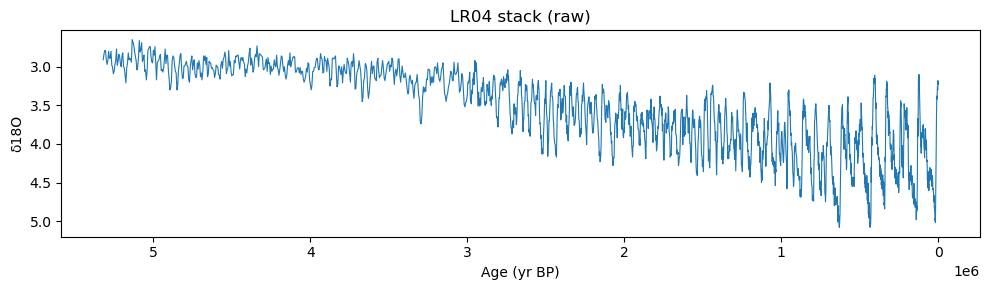

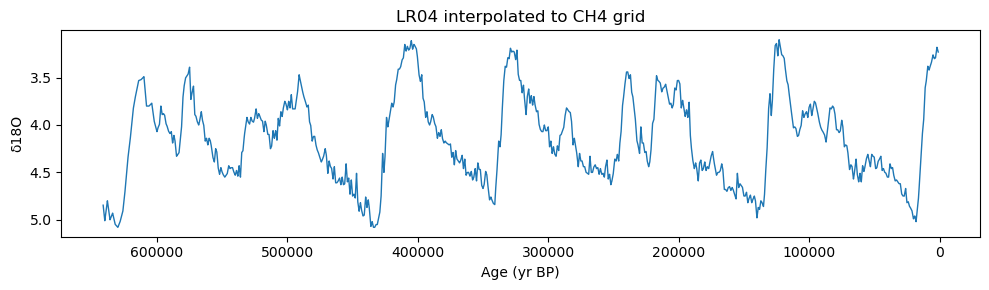

Best σ‐multiplier = 0.40   |   F1(cold) = 0.685   |   predicted runs = 40   |   score = 0.649


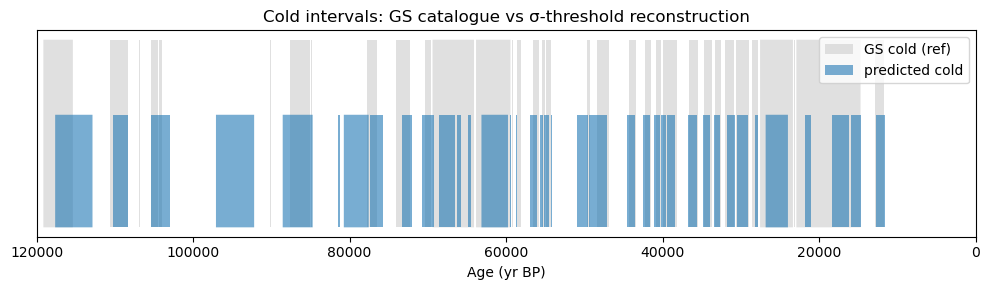

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from pyinform import transfer_entropy
from toolbox import sq_ana as sa 
import importlib
importlib.reload(sa)

# ------------------------------------------------------------------
#  A) Prepare / interpolate data exactly as before
# ------------------------------------------------------------------
df_lr04_interp = sa.interpolate_data_lr04(
    df_filt_ch4,      # any DataFrame with an 'age' column
    if_plot=True
)

# Crop the LR04‐interpolated DataFrame to age ≥ 10 000
df_lr04_interp = df_lr04_interp[df_lr04_interp['age'] >= 10_000].reset_index(drop=True)
df_lr04_interp['d18O'] *= -1

# Extract “full” LR04 and CH4 (no cropping yet), then flip to forward‐time
lr04_full = df_lr04_interp['d18O'].values[::-1]
sq_full   = df_filt_ch4['filt_ch4'].values[::-1]
ages_full = df_lr04_interp['age'].values[::-1]  # (not strictly needed past this point)

# Compute σ on the ENTIRE CH4 record (sq_full)
sigma_full = np.std(sq_full)


# GS (Greenland Stadial) start/end ages (on 10–120 ka window)
gs_data = {
    "start": np.array([11703, 14692, 23020, 23340, 27780, 28900, 30840, 32500, 33740, 35480,
                       38220, 40160, 41460, 43340, 46860, 49280, 54220, 55000, 55800, 58040,
                       58280, 59080, 59440, 64100, 69620, 72340, 76440, 84760, 85060, 90040,
                       104040,104520,106750,108280,115370]),
    "end":   np.array([12896, 22900, 23220, 27540, 28600, 30600, 32040, 33360, 34740, 36580,
                       39900, 40800, 42240, 44280, 48340, 49600, 54900, 55400, 56500, 58160,
                       58560, 59300, 63840, 69400, 70380, 74100, 77760, 84960, 87600, 90140,
                       104380,105440,106900,110640,119140])
}

# ------------------------------------------------------------------
#  B) Align CH4 to the LR04 age grid (10 ka – 120 ka) and define masks
# ------------------------------------------------------------------
age_min, age_max = 10_000, 120_000
mask_range = (df_filt_ch4['age'] >= age_min) & (df_filt_ch4['age'] <= age_max)

df_ch4_crop = df_filt_ch4.loc[mask_range].reset_index(drop=True)

# Now restrict both LR04 & CH4 to 10–120 ka, and flip to forward (BP → present) order
ages = df_lr04_interp.loc[
            (df_lr04_interp['age'] >= age_min) &
            (df_lr04_interp['age'] <= age_max),
        'age'
     ].iloc[::-1].values

lr04 = df_lr04_interp.loc[mask_range, 'd18O'].iloc[::-1].values
sq   = df_ch4_crop['filt_ch4'].iloc[::-1].values

# Sanity check: lengths must match
assert len(ages) == len(sq) == len(lr04)

# ------------------------------------------------------------------
#  C) Build the “full‐length” state‐series helper using sigma_full
# ------------------------------------------------------------------
def build_state_full(signal_cropped, sigma_mult, sigma_base):
    """
    Build a {0,1} state‐series for `signal_cropped`, but using
      thr = sigma_mult * sigma_base
    where sigma_base is the std of the *entire* CH4 record.
    
    This function internally constructs the full‐length state array
    of the cropped signal in forward‐time. Any “neutral” (NaN) region
    is filled forward, and leading NaNs are set to the first valid state.
    """
    thr = sigma_mult * sigma_base
    st  = np.full_like(signal_cropped, np.nan, float)
    st[signal_cropped <= -thr] = 0
    st[signal_cropped >=  thr] = 1

    # propagate last‐known state forward
    for i in range(1, len(st)):
        if np.isnan(st[i]):
            st[i] = st[i-1]
    # fill any leading NaNs with first non‐NaN
    first = np.where(~np.isnan(st))[0][0]
    st[:first] = st[first]

    return st.astype(int)


# GS mask on the 10–120 ka “ages” grid
mask_gs = np.zeros_like(ages, dtype=bool)
for s, e in zip(gs_data['start'], gs_data['end']):
    mask_gs |= (ages >= s) & (ages <= e)

# Restrict evaluation domain (here identical to full array = 10–120 ka)
domain = np.full_like(ages, True, dtype=bool)

# ------------------------------------------------------------------
#  D) Scoring helpers: f1_cold and n_runs
# ------------------------------------------------------------------
def f1_cold(pred_mask, true_mask):
    TP = np.sum(pred_mask & true_mask)
    FP = np.sum(pred_mask & ~true_mask)
    FN = np.sum(~pred_mask & true_mask)
    if TP + FP == 0 or TP + FN == 0:
        return 0.0
    prec = TP / (TP + FP)
    rec  = TP / (TP + FN)
    return 2 * prec * rec / (prec + rec)

def n_runs(mask):
    edges = np.diff(np.r_[False, mask, False].astype(int))
    return np.sum(edges == 1)

n_gs_runs = len(gs_data['start'])  # 35 stadials
alpha     = 0.25                   # penalty weight

# ------------------------------------------------------------------
#  E) σ grid‐search, **using sigma_full** instead of std(cropped)
# ------------------------------------------------------------------
sigmas    = np.arange(0.1, 3.05, 0.1)
best_score = -np.inf
best_mult  = None
best_state = None

for m in sigmas:
    # Build the cropped state‐series, but always threshold with sigma_full:
    st = build_state_full(sq, m, sigma_full)
    cold_pred = (st == 0)

    # 1) F1(cold) on the (10–120 ka) domain
    f1 = f1_cold(cold_pred[domain], mask_gs[domain])

    # 2) Parsimony penalty based on number of predicted runs
    n_pred_runs = n_runs(cold_pred[domain])
    penalty = alpha * abs(n_pred_runs - n_gs_runs) / n_gs_runs

    score = f1 - penalty
    if score > best_score:
        best_score, best_mult, best_state = score, m, st
        best_f1        = f1
        best_n_pred    = n_pred_runs

print(
    f'Best σ‐multiplier = {best_mult:.2f}'
    f'   |   F1(cold) = {best_f1:.3f}'
    f'   |   predicted runs = {best_n_pred}'
    f'   |   score = {best_score:.3f}'
)

state = best_state  # This “state” is already cropped via build_state_full

# ------------------------------------------------------------------
#  F) Visual check of reconstruction vs GS catalogue (10–120 ka)
# ------------------------------------------------------------------
plt.figure(figsize=(10, 3))
plt.fill_between(ages, 0, 1, where=mask_gs, facecolor='lightgrey',
                 step='pre', alpha=.7, label='GS cold (ref)')
plt.fill_between(ages, 0, .6, where=(state == 0), facecolor='C0',
                 step='pre', alpha=.6, label='predicted cold')
plt.xlim(120000, 0)
plt.yticks([])
plt.xlabel('Age (yr BP)')
plt.legend(loc='upper right')
plt.title('Cold intervals: GS catalogue vs σ‐threshold reconstruction')
plt.tight_layout()
plt.show()


# LR04 to raw CH4 MCV

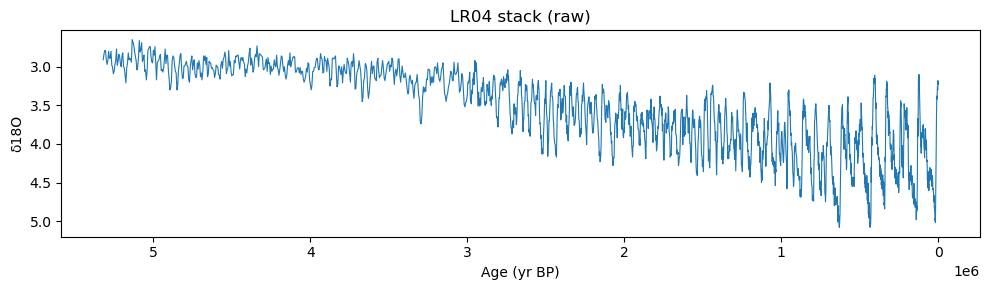

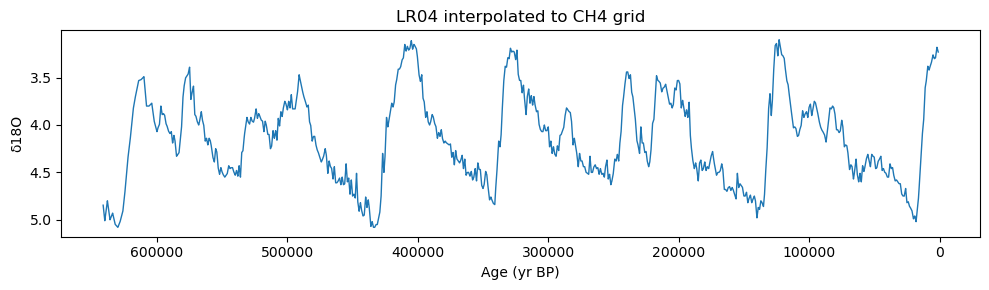

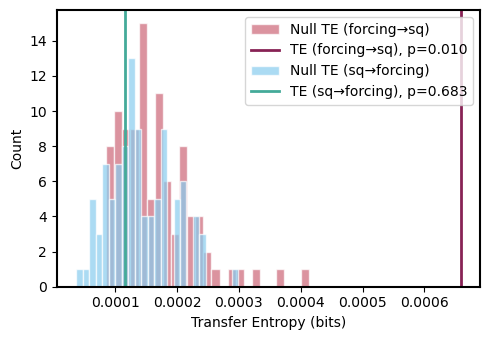

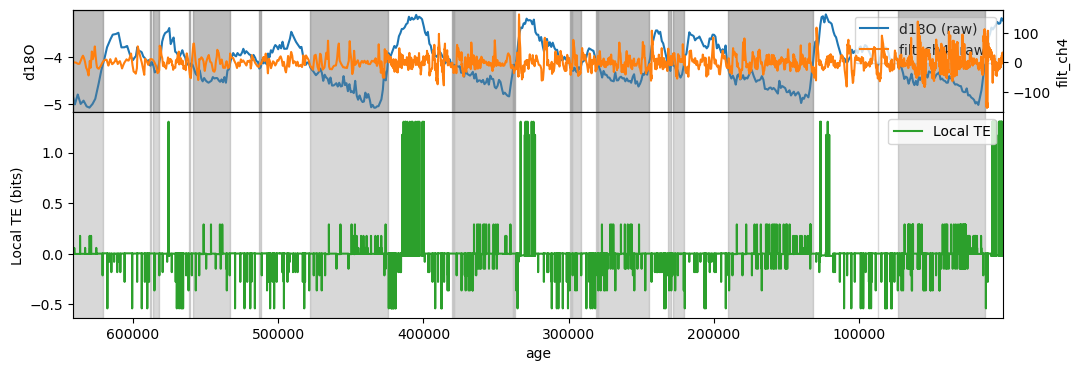

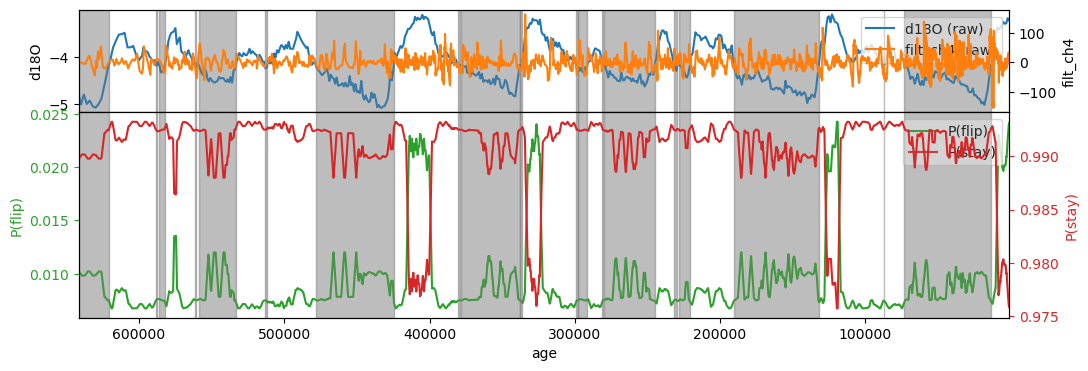

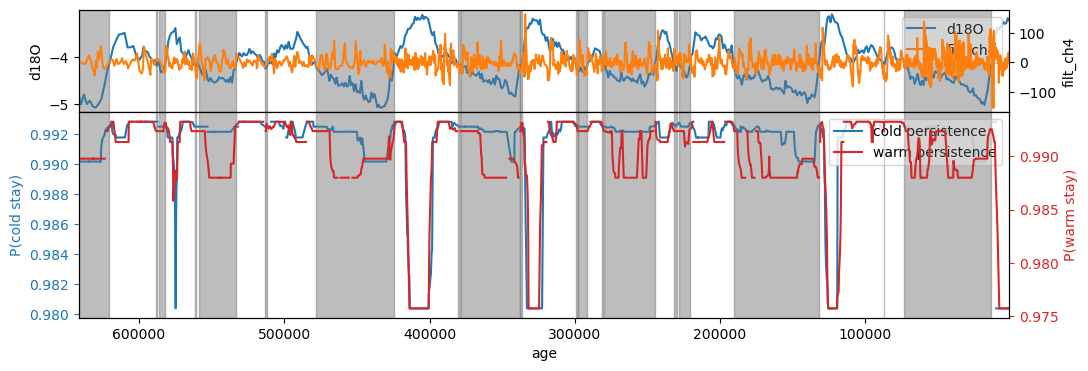

In [7]:
from toolbox import sq_ana as sa 
import importlib
importlib.reload(sa)

df_lr04_interp = sa.interpolate_data_lr04(
    df_filt_ch4,      # any DataFrame with an 'age' column
    if_plot=True
)


df_lr04_interp['d18O']=df_lr04_interp['d18O']*-1

lr04= df_lr04_interp['d18O'].values  # LR04 benthic stack
sq = df_filt_ch4['filt_ch4'].values    # target (residual)


result,fig=sa.transfer_entropy_surrogate_test(lr04,sq, forcing_bins=6, sq_bins=2, n_surr=100)



LTE = sa.local_TE(df_lr04_interp.copy(), df_filt_ch4.copy(),
                   forcing_column='d18O',
                   target_column='filt_ch4',
                   time_column='age',
                   nbins_pre=6,
                   nbins_target=2)



Lp = sa.local_prob(df_lr04_interp.copy(), df_filt_ch4.copy(),
                   forcing_column='d18O',
                   target_column='filt_ch4',
                   time_column='age',
                   nbins_pre=6,
                   smooth_win=300)


Lp = sa.local_stay_split(df_lr04_interp.copy(), df_filt_ch4.copy(),
                   forcing_column='d18O',
                   target_column='filt_ch4',
                   time_column='age',
                   nbins_pre=6,
                   smooth_win=300)

In [ ]:
print(df_lr04_interp['d18O'].max(), 'should be interglacial ‖ warm')
print(df_lr04_interp['d18O'].min(), 'should be glacial ‖ cold')


-3.1 should be interglacial ‖ warm
-5.08 should be glacial ‖ cold


,age,lr04
0,97400,4.8397
1,97300,4.8527
2,97200,4.8657
3,97100,4.8787
4,97000,4.8926
...,...,...
970,400,3.8472
971,300,3.8352
972,200,3.8232
973,100,3.8112
